In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
data = pd.read_csv('CNCnoise_1.csv', header=None)

In [4]:
data.head()

,0
0,1911
1,1933
2,1901
3,1939
4,1914


In [5]:
data = data.rename(columns={0: "noise"})

<Axes: >

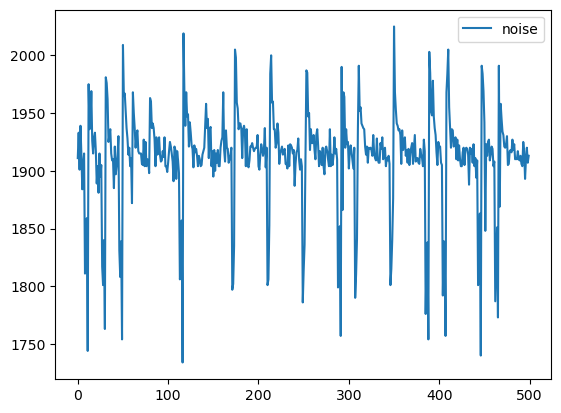

In [6]:
sns.lineplot(data[:500])

주기성을 띔

# Z-score

In [7]:
from scipy.stats import zscore

data['z_score'] = np.abs(zscore(data))
data.head()

,noise,z_score
0,1911,0.117391
1,1933,0.279599
2,1901,0.297841
3,1939,0.387869
4,1914,0.063256


In [8]:
outlier_mask = data['z_score'].abs() > 2

In [9]:
data['is_outlier_z_score'] = data['z_score'].abs() > 2

In [10]:
data

,noise,z_score,is_outlier_z_score
0,1911,0.117391,False
1,1933,0.279599,False
2,1901,0.297841,False
3,1939,0.387869,False
4,1914,0.063256,False
...,...,...,...
634755,1913,0.081301,False
634756,1915,0.045211,False
634757,1914,0.063256,False
634758,1914,0.063256,False


# IQR
안됨(극단값 없음)

In [11]:
q1 = np.percentile(data['noise'], 25)
q3 = np.percentile(data['noise'], 75)

print(f"Q1: {q1}, Q3: {q3}")

Q1: 1911.0, Q3: 1929.0


In [12]:
Q1 = data['noise'].quantile(0.25)
Q3 = data['noise'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = (data['noise'] < lower_bound) | (data['noise'] > upper_bound)

data['is_outlier_IQR'] = outlier_mask

outlier_indices = data.index[outlier_mask]

data.loc[outlier_mask, ['noise']]

,noise
8,1811
9,1840
10,1859
11,1744
12,1975
...,...
634724,2007
634725,1985
634726,1968
634727,2002


<Axes: xlabel='None', ylabel='noise'>

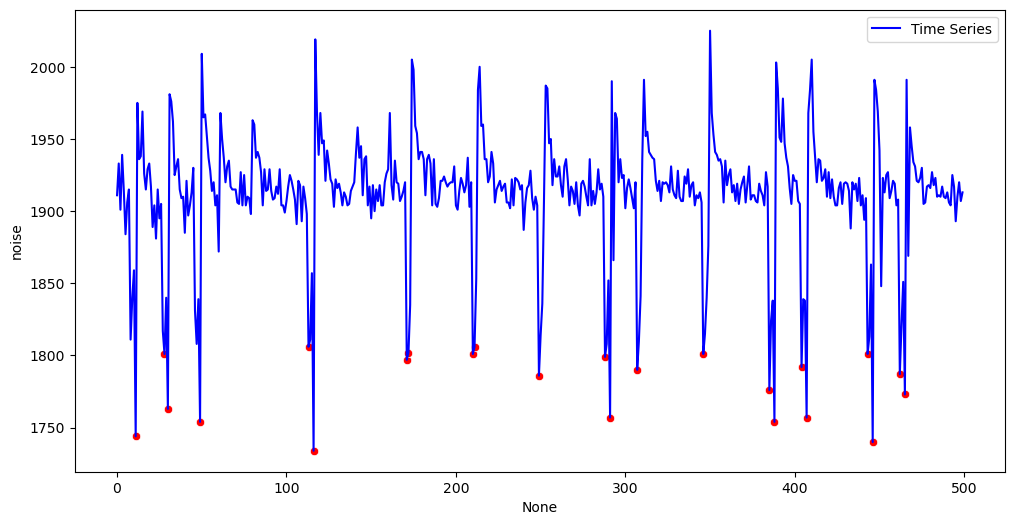

In [13]:
df_500 = data.iloc[:500]

plt.figure(figsize=(12, 6))
sns.lineplot(x=df_500.index, y=df_500['noise'], label='Time Series', color='blue')

# 이상치만 빨간 점으로 표시
sns.scatterplot(
    x=df_500.index[df_500['is_outlier_z_score']],
    y=df_500['noise'][df_500['is_outlier_z_score']],
    color='red'
)

<Axes: xlabel='None', ylabel='noise'>

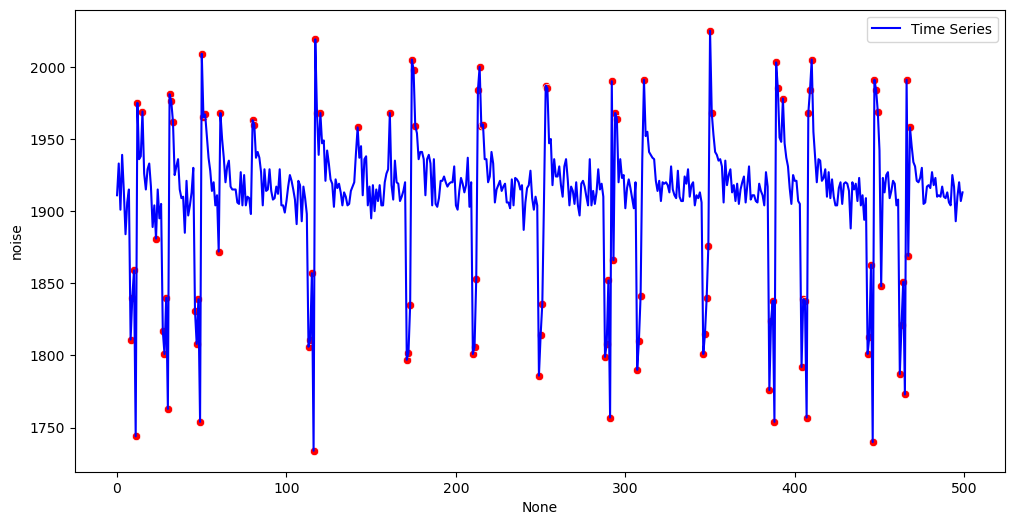

In [14]:
df_500 = data.iloc[:500]

plt.figure(figsize=(12, 6))
sns.lineplot(x=df_500.index, y=df_500['noise'], label='Time Series', color='blue')

# 이상치만 빨간 점으로 표시
sns.scatterplot(
    x=df_500.index[df_500['is_outlier_IQR']],
    y=df_500['noise'][df_500['is_outlier_IQR']],
    color='red'
)

## Z-Score vs IQR 이상치 탐지 분석

- 결과차이: IQR 방법이 Z-score 방법보다 훨씬 많은 이상치를 탐지함 -> IQR이 더 작은 변화에도 Z-score보다 민감하게 반응함(일반적인 현상)
- 위 시계열 데이터는 주기성을 보임
- 낮아졌다가 높아지는 주기를 띄는데 통계치를 이용하여 분석한 이상치들은 주기마다 낮아지는 지점과 높아지는 지점 모두를 이상치로 판단함
- 시계열 데이터에서 통계적 방법으로 이상치를 탐지하는 것은 적절하지 않아보임

### 개선점
#### 1. 시계열 데이터용 이상치 탐색방법 사용
- 시계열용 알고리즘 사용
#### 2. 도메인 지식 반영(예측까지 한다는 가정하에)
CNC 머신의 정상적인 작업 패턴을 이해하여 접근    
CNC 머신의 작동 원리와 정상적인 소음 패턴과 범주를 알아두는 것이 좋을듯함
- 채터 현상: 비정상적인 진동
- 스핀들 베어링 문제: 기계적 결함
- 절삭 조건 불안정: 공구 마모나 설정 오류

In [15]:
data

,noise,z_score,is_outlier_z_score,is_outlier_IQR
0,1911,0.117391,False,False
1,1933,0.279599,False,False
2,1901,0.297841,False,False
3,1939,0.387869,False,False
4,1914,0.063256,False,False
...,...,...,...,...
634755,1913,0.081301,False,False
634756,1915,0.045211,False,False
634757,1914,0.063256,False,False
634758,1914,0.063256,False,False


In [17]:
from statsmodels.tsa.seasonal import STL

stl = STL(data['noise'], period=45)
result = stl.fit()

residual = result.resid

z_scores = (residual - residual.mean()) / residual.std()
threshold = 3  
data['is_outlier_STL'] = np.abs(z_scores) > threshold

<Axes: xlabel='None', ylabel='noise'>

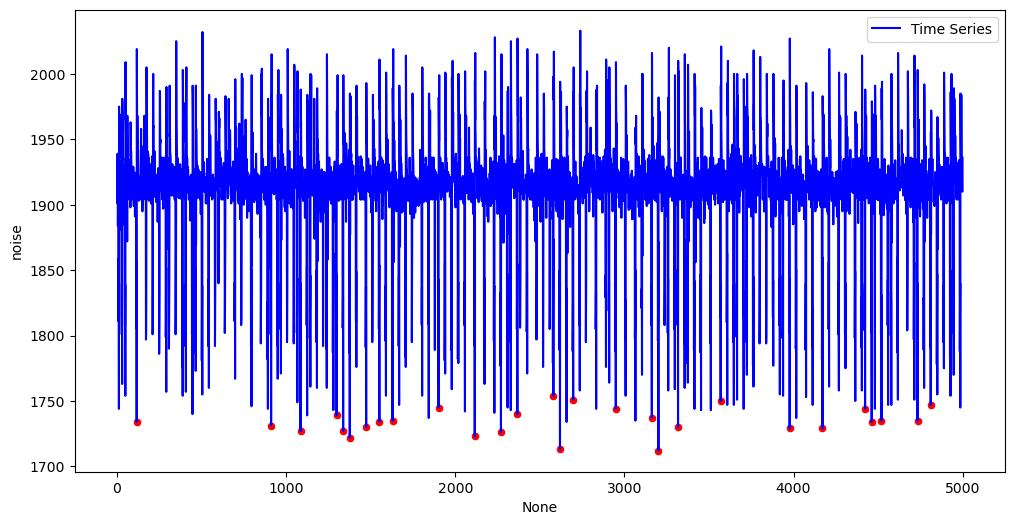

In [21]:
df_5000 = data.iloc[:5000]
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_5000.index, y=df_5000['noise'], label='Time Series', color='blue')

# 이상치만 빨간 점으로 표시
sns.scatterplot(
    x=df_5000.index[df_5000['is_outlier_STL']],
    y=df_5000['noise'][df_5000['is_outlier_STL']],
    color='red'
)